In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.constants import IMAGENET_MEAN, IMAGENET_STD
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.image_classification.models import BamResNet
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [3]:
artifact_path = Path("../../artifacts/bam")
data_path = Path("../../data/animal10")

In [4]:
device = torch.device("cuda:0")

# data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [6]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [8]:
num_class = len(dataset.classes)

# model

In [9]:
model = BamResNet(output_size=num_class, num_layer=50).to(device)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
BamResNet                                          --
├─Sequential: 1-1                                  --
│    └─ConvBnRelu: 2-1                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    └─MaxPool2d: 2-2                              --
├─Sequential: 1-2                                  --
│    └─ResBlock: 2-3                               --
│    │    └─BottleNeck: 3-4                        58,112
│    │    └─ConvBnRelu: 3-5                        16,896
│    └─ResBlock: 2-4                               --
│    │    └─BottleNeck: 3-6                        70,400
│    │    └─Identity: 3-7                          --
│    └─ResBlock: 2-5                               --
│    │    └─BottleNeck: 3-8                        70,400
│    │    └─Identity: 3-9                          --
├─S

# training

In [11]:
epoches = 10
acc_iters = 64 // BATCH_SIZE

In [12]:
trainer = ClassificationTrainer(epoches, device, acc_iters)

In [13]:
criterion = trainer.get_criterion(num_class)
optim = torch.optim.Adam(model.parameters(), weight_decay=1e-5)

In [14]:
training_loss = trainer.run(train_loader, model, optim, criterion)

100%|██████████| 1636/1636 [05:16<00:00,  5.17it/s]


epoch 1 : 0.030161211385521445


100%|██████████| 1636/1636 [04:49<00:00,  5.65it/s]


epoch 2 : 0.022974302576658997


100%|██████████| 1636/1636 [04:49<00:00,  5.64it/s]


epoch 3 : 0.01940277751454341


100%|██████████| 1636/1636 [04:49<00:00,  5.66it/s]


epoch 4 : 0.01644525153694497


100%|██████████| 1636/1636 [04:49<00:00,  5.66it/s]


epoch 5 : 0.014382842436608173


100%|██████████| 1636/1636 [04:52<00:00,  5.59it/s]


epoch 6 : 0.012749242779063311


100%|██████████| 1636/1636 [04:49<00:00,  5.65it/s]


epoch 7 : 0.011412903880114122


100%|██████████| 1636/1636 [04:49<00:00,  5.66it/s]


epoch 8 : 0.010293732766713264


100%|██████████| 1636/1636 [04:50<00:00,  5.62it/s]


epoch 9 : 0.009306505532089329


100%|██████████| 1636/1636 [04:49<00:00,  5.66it/s]

epoch 10 : 0.00837307944754722


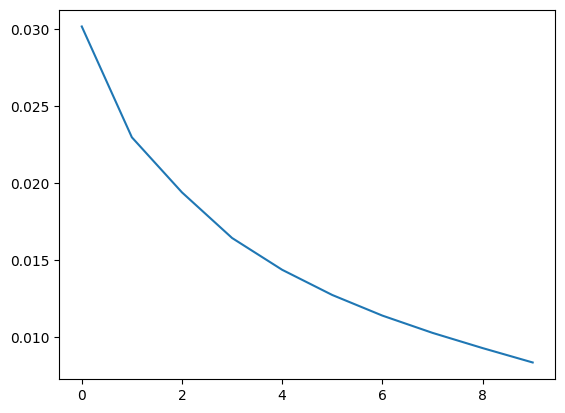

In [15]:
plt.plot(training_loss)

# inference

In [16]:
test_preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [17]:
test_dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=test_preprocess,
)

In [18]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=get_num_workers(),
)

In [19]:
evaluator = ClassificationEvaluator(num_class, device)

In [20]:
confusion_matrix = evaluator.run(test_loader, model)

  0%|          | 0/1637 [00:00<?, ?it/s]

100%|██████████| 1637/1637 [02:19<00:00, 11.73it/s]

[[3912  125   47   14   69  335   22   15  117  207]
 [ 109 2231   41   15   37   32   40   11   55   52]
 [  31   18 1279    2   17   19    6    9   35   30]
 [  14    1    3 1707   23   82    3    0  234   45]
 [  62    5    4   18 2820   45    1    6   75   62]
 [  82    3    4    3   11 1445    0    2   27   91]
 [ 155  140   51    1   28   26 1294  105   25   41]
 [ 138   30   63    2   46   84   70 1241   35  111]
 [  30    4    4   63   22   83    0    3 4527   85]
 [  25    2    5   12   14   28    0    1   48 1727]]


In [21]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(test_dataset.classes, per_class_acc)

cane      : 0.8044417026526836
cavallo   : 0.85055280213496
elefante  : 0.8845089903181189
farfalla  : 0.8082386363636364
gallina   : 0.9102646868947708
gatto     : 0.8663069544364509
mucca     : 0.6934619506966774
pecora    : 0.6818681318681319
ragno     : 0.9390168014934661
scoiattolo: 0.9274973147153598


In [22]:
per_class_acc.mean()

0.8366157971574255

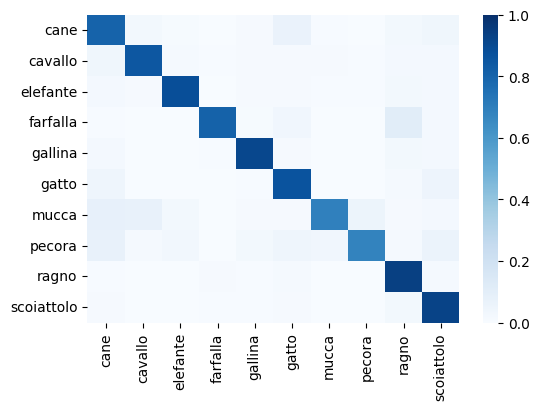

In [23]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    test_dataset.classes,
    "Blues",
    annot=False,
    figsize=(6, 4),
)

In [24]:
model_path = artifact_path / 'bam-resnet50.pth'

In [25]:
torch.save(model.state_dict(), model_path)

In [26]:
get_file_size(model_path)

'91.38MB'

In [27]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>